In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import tensorflow as tf

import sys
sys.path.append('../')

from gpflow.params import Parameterized
from gpflow import autoflow, params_as_tensors
from gpflow.kernels import RBF
from gpflow.likelihoods import Gaussian

from doubly_stochastic_dgp.dgp import DGP, DGP_quad

# plotting
import matplotlib.pyplot as plt

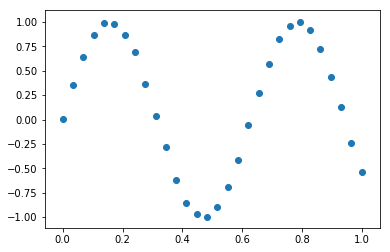

In [3]:
kerns = lambda : [RBF(1, lengthscales=0.001, variance=0.2), RBF(1, lengthscales=0.2)]

def lik():
    l = Gaussian()
    l.variance = 0.01
    return l

N = 30
M = 100
X = np.linspace(0, 1, N).reshape(-1, 1)
Z = np.linspace(-2, 2, M).reshape(-1, 1)
Y = np.sin(10*X) + np.random.randn(*X.shape) * 0.01
plt.scatter(X, Y)
plt.show()

In [4]:
model_dgp_2_1 = DGP(X, Y, Z, kerns(), lik(), num_samples=1)
model_dgp_2_5 = DGP(X, Y, Z, kerns(), lik(), num_samples=5)
model_dgp_2_100 = DGP(X, Y, Z, kerns(), lik(), num_samples=100)
# model_dgp_2_1000 = DGP(X, Y, Z, kerns(), lik(), num_samples=1000)

model_dgp_2_quad_2 = DGP_quad(X, Y, Z, kerns(), lik(), H=2)
model_dgp_2_quad_5 = DGP_quad(X, Y, Z, kerns(), lik(), H=5)
model_dgp_2_quad_10 = DGP_quad(X, Y, Z, kerns(), lik(), H=10)
model_dgp_2_quad_20 = DGP_quad(X, Y, Z, kerns(), lik(), H=20)
# model_dgp_2_quad_100 = DGP_quad(X, Y, X, kerns(), lik(), H=100)

models = [model_dgp_2_1,
          model_dgp_2_5,
          model_dgp_2_100,
#           model_dgp_2_1000,
          model_dgp_2_quad_2,
          model_dgp_2_quad_5,
          model_dgp_2_quad_10,
          model_dgp_2_quad_20,
#           model_dgp_2_quad_100]
         ]
          

In [6]:
for layers in zip(*[model.layers for model in models]):
    q_mu = np.random.randn(M, 1)
    q_sqrt = np.random.randn(M, M, 1)
    
    for layer in layers:
        layer.q_mu = q_mu
        layer.q_sqrt = q_sqrt
    

In [7]:
Ls = [[model.compute_log_likelihood() for _ in range(50)] for model in models]


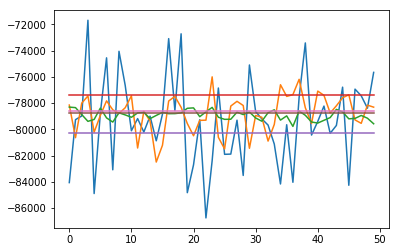

In [8]:
for l in Ls:
    plt.plot(l)

plt.show()

In [9]:
for l in Ls:
    print(np.average(l))

-79362.3181295
-78788.4103211
-78940.0019187
-77412.4594392
-80247.5325197
-78758.2255185
-78569.2307705


In [ ]:
# class DGP_with_z(DGP)
#     @params_as_tensors
#     @autoflow(tf.float64, [None, None, None])
#     def log_p_y_manual_z(self, zs):
#         Q = tf.shape(z)[0]
#         HX = tf.tile(tf.expand_dims(X, 0), [Q, 1, 1]) # Q, N, D_x
#         Fs = [HX, ]
#         Fmeans, Fvars = [], []
        
#         z_list = []
#         s, e = 0, 0
#         for layer in self.layers:
#             s += tf.shape(layer.q_mu)[1]
#             z_list.append(z[:, s:e])
#             e += tf.shape(layer.q_mu)[1]
            
#         for z, layer in zip(z_list, self.layers):
#             if layer.forward_propagate_inputs:
#                 X_inputs = tf.concat([HX, Fs[-1]], 2)
#             else:
#                 X_inputs = Fs[-1]

#             mean, var = layer.multisample_conditional(X_inputs, full_cov=False)

#             F = mean + var**0.5 * z[:, None, :]  # Q, N, D

#             Fs.append(F)
#             Fmeans.append(mean)
#             Fvars.append(var)

#         return = self.likelihood_variational_expectations(Fmeans[-1], Fvars[-1], self.Y)  # Q, N, D
